In [1]:
%matplotlib inline

In [2]:
import os
from pathlib import Path

import cortex
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt 

import nilearn
from nilearn.image import smooth_img

In [3]:
print("cortex", cortex.__version__)
print("nibabel", nib.__version__)
print("nilearn", nilearn.__version__)
print("numpy", np.__version__)
import matplotlib
print('matplotlib version: ', matplotlib.__version__)

cortex 1.2.5
nibabel 5.2.1
nilearn 0.10.4
numpy 1.23.4
matplotlib version:  3.7.5


# t-values from t-tests between Memory Conditions projected onto Individual Flat Maps

This notebook includes code to visualize the results (t-scores) onto subject-specific cortical flat maps as seen in:

* **Fig 3C, Memory Recognition**.

**To run the cells**, you will need to:

1. Pull files from the following submodule: 
* ***cneuromod-things/anatomical/pycortex***

2. Pull the following input files: 
* ***cneuromod-things/THINGS/glm-memory/sub-{s}/glm/sub-{s}_task-things_space-T1w_contrast-{HitvCorrectRej, HitWithinvCorrectRej, HitBtwnvCorrectRej}_stat-{t, p}_desc-fromBetas_statmap.nii.gz***

3. Install pycortex:
* To do so, follow the instructions from the **cneuromod-things/anatomical/pycortex** submodule's README.md file. 



In [4]:
# set Freesufer variable SUBJECTS_DIR to "path/to/cneuromod-things/anatomical/smriprep/sourcedata/freesurfer"

fs_path = f'{Path("../../anatomical/smriprep/sourcedata/freesurfer").resolve()}'

os.environ['SUBJECTS_DIR'] = fs_path

#!echo $SUBJECTS_DIR      

In [5]:
# Set paths 

glm_path = Path("../../THINGS/glm-memory").resolve()
fig_save_path = Path("../figures").resolve()


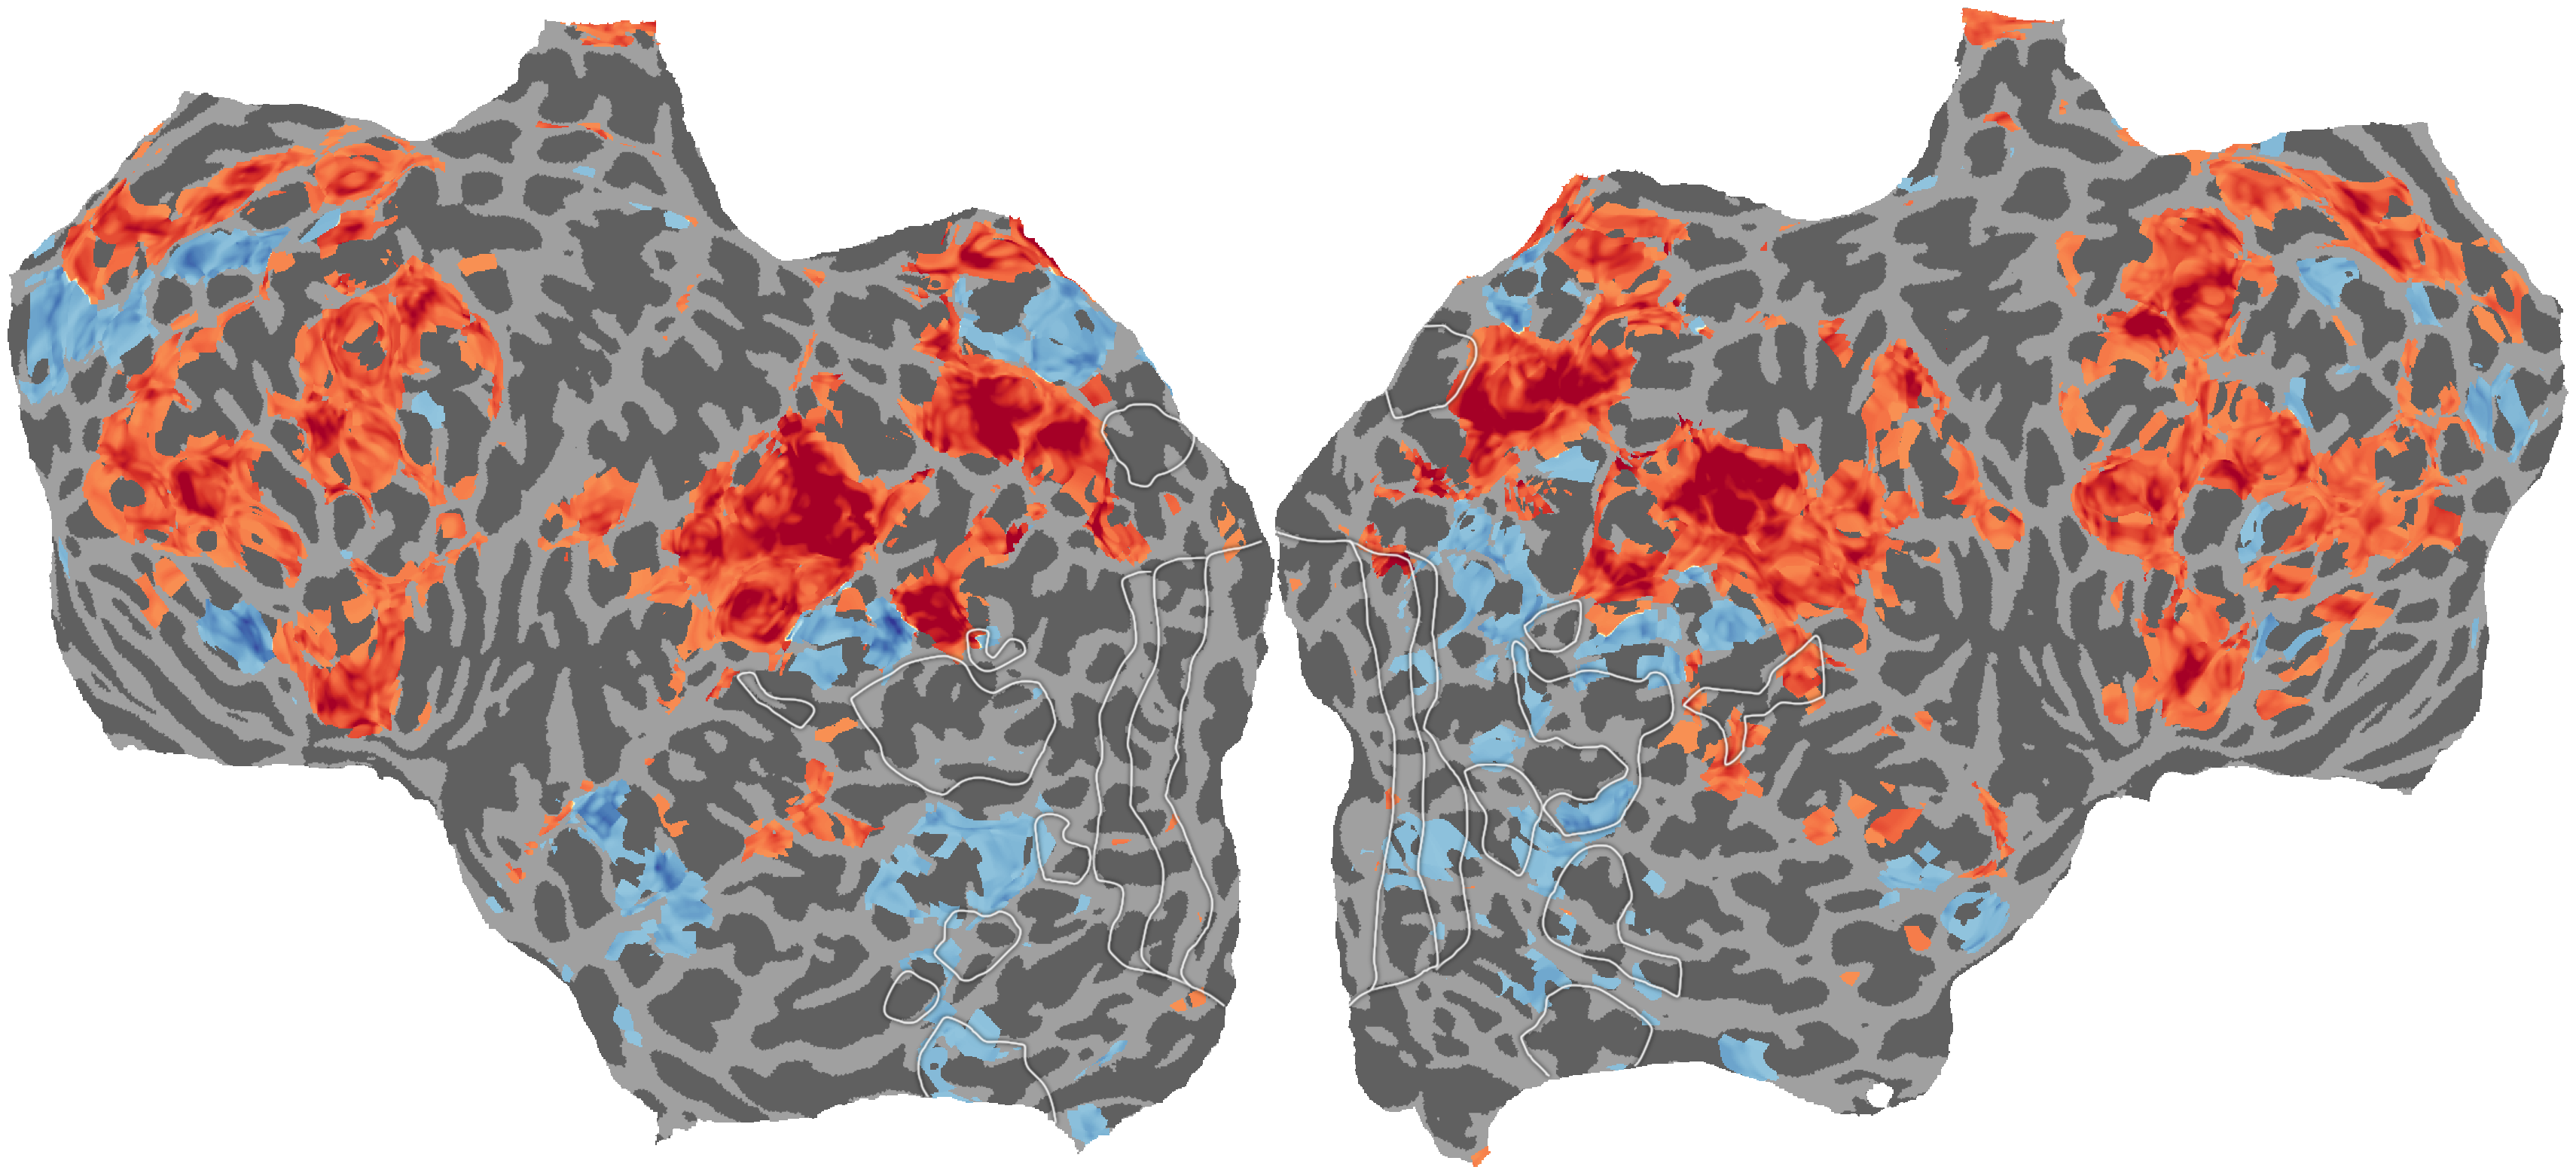

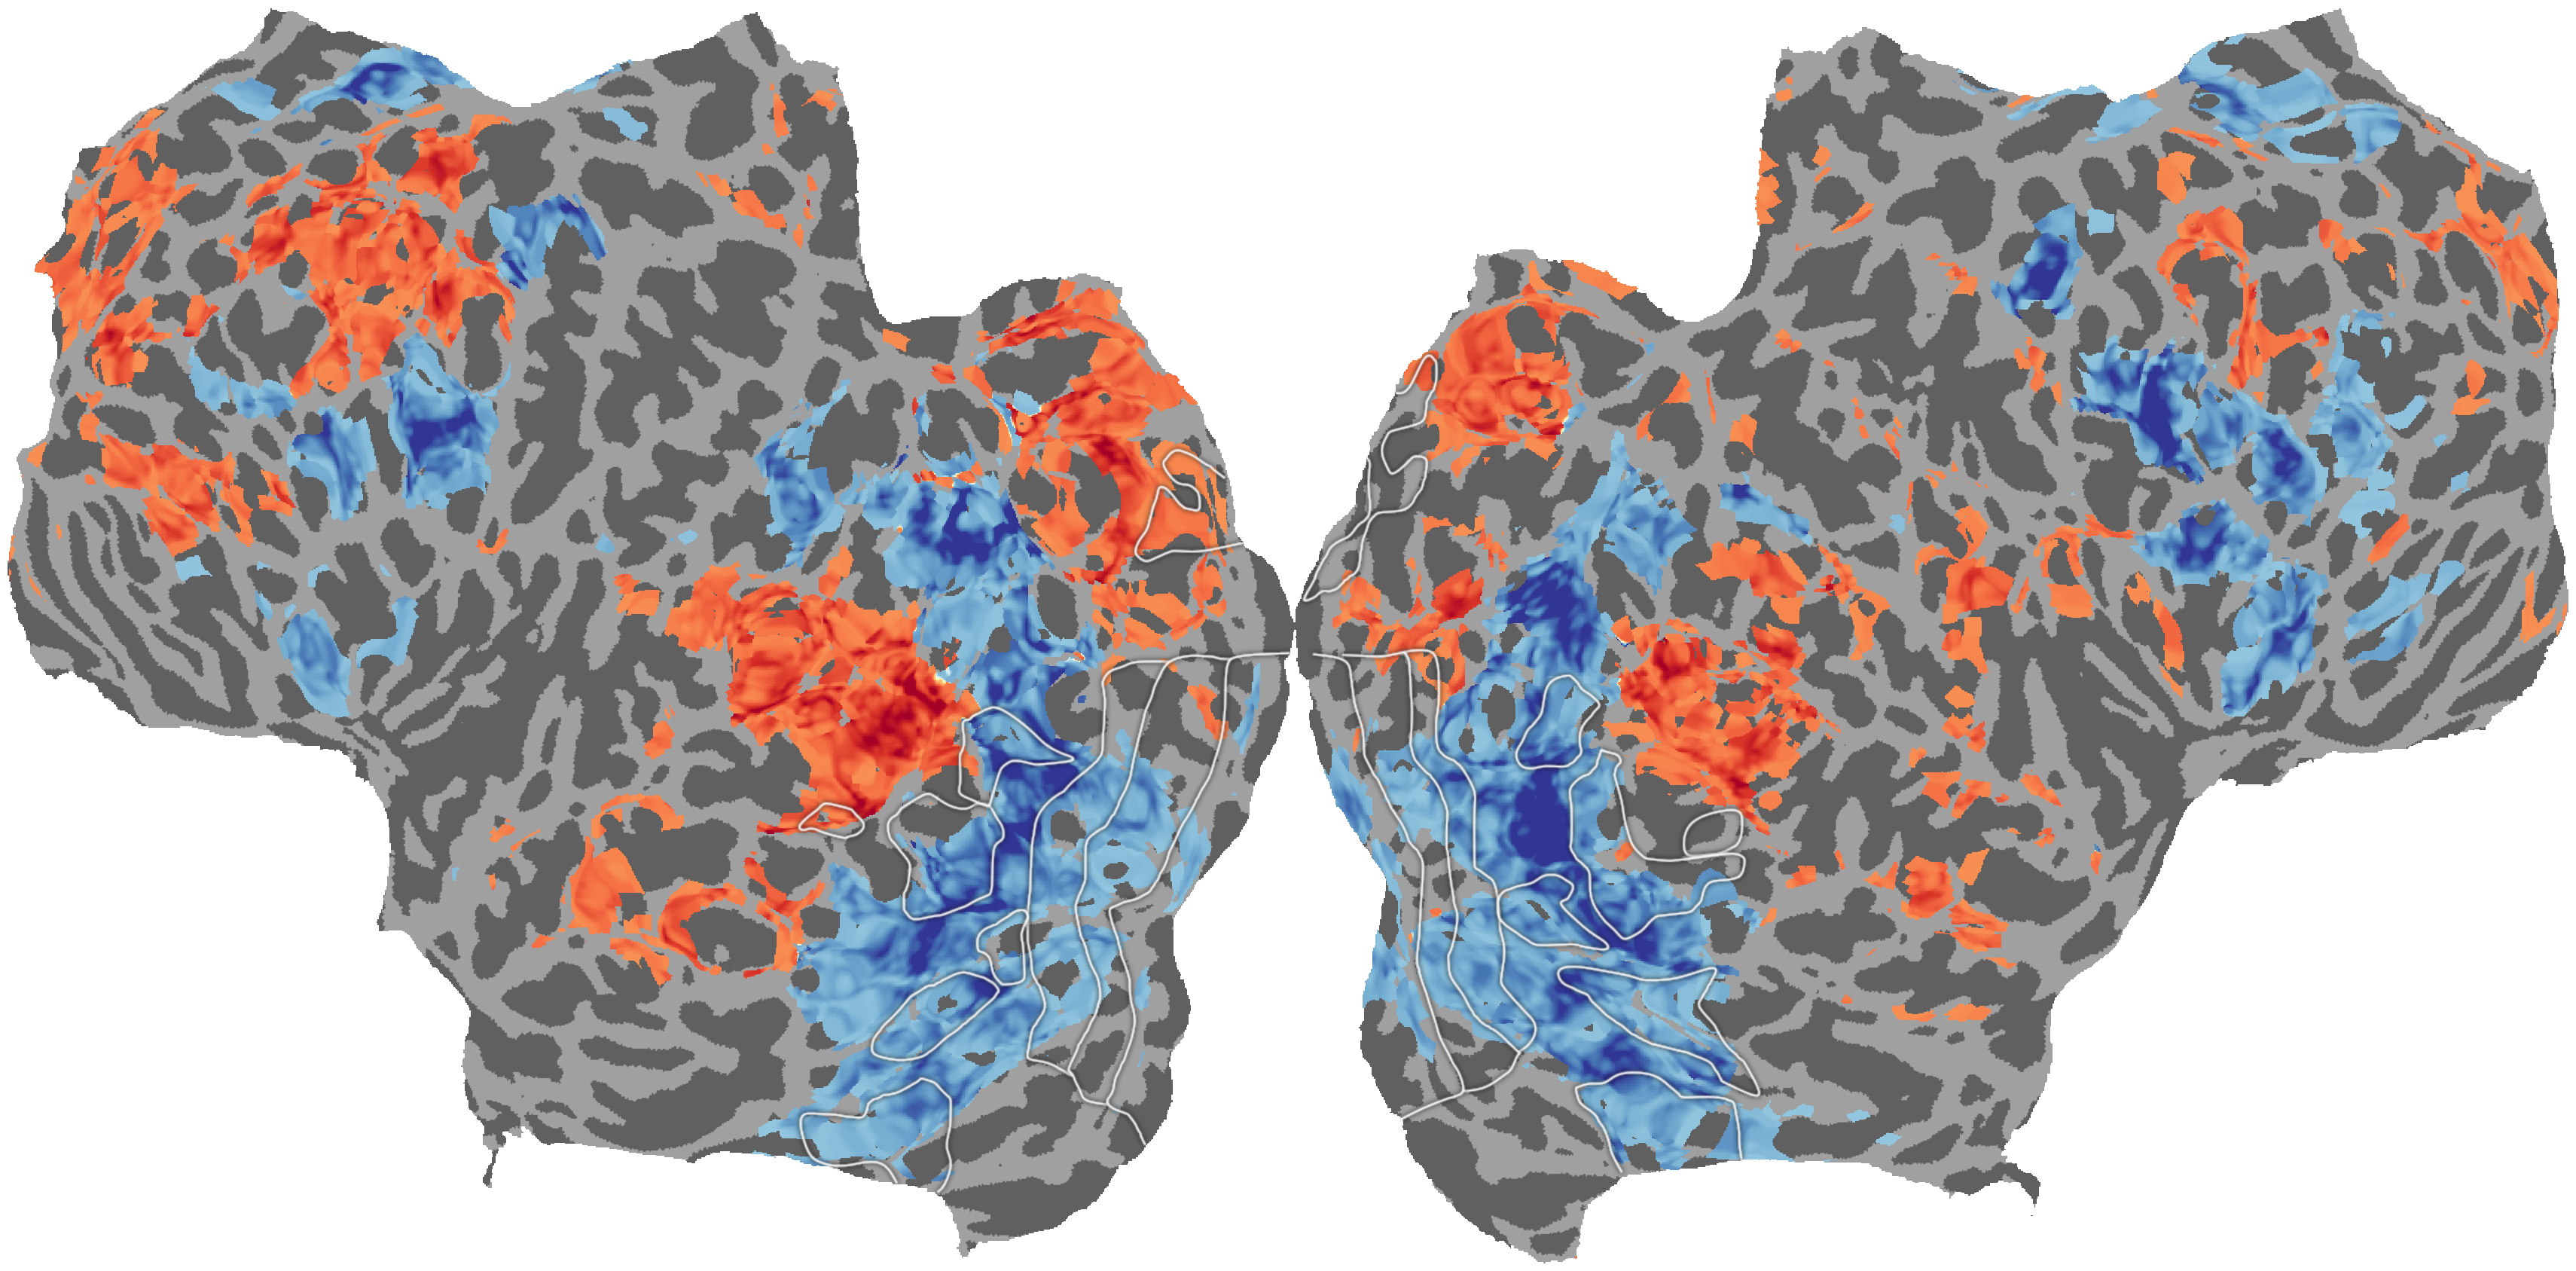

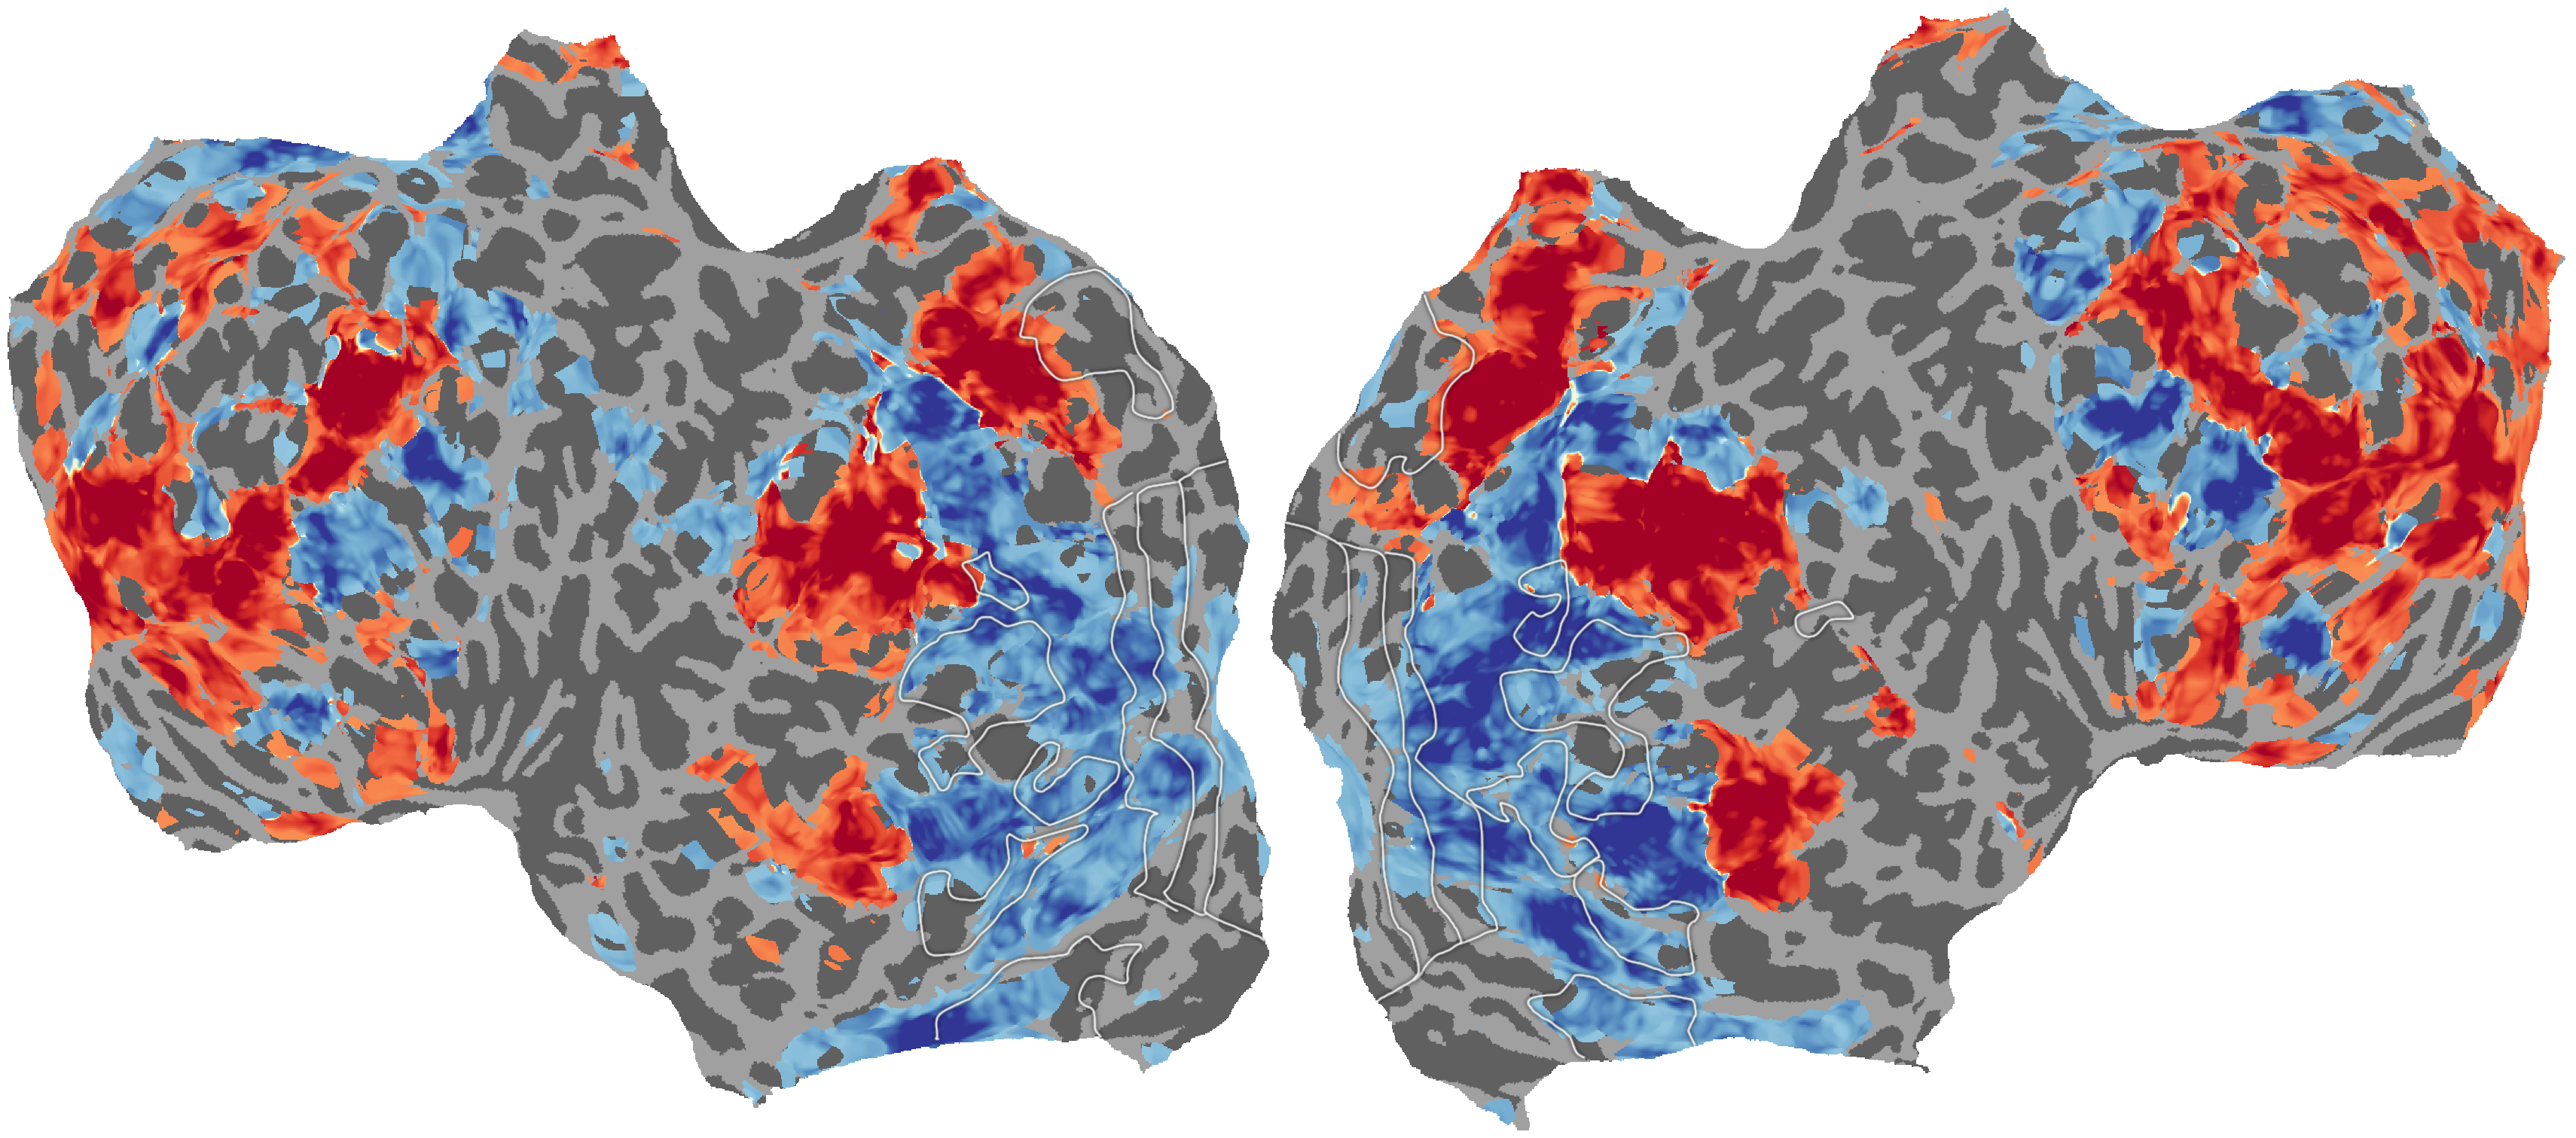

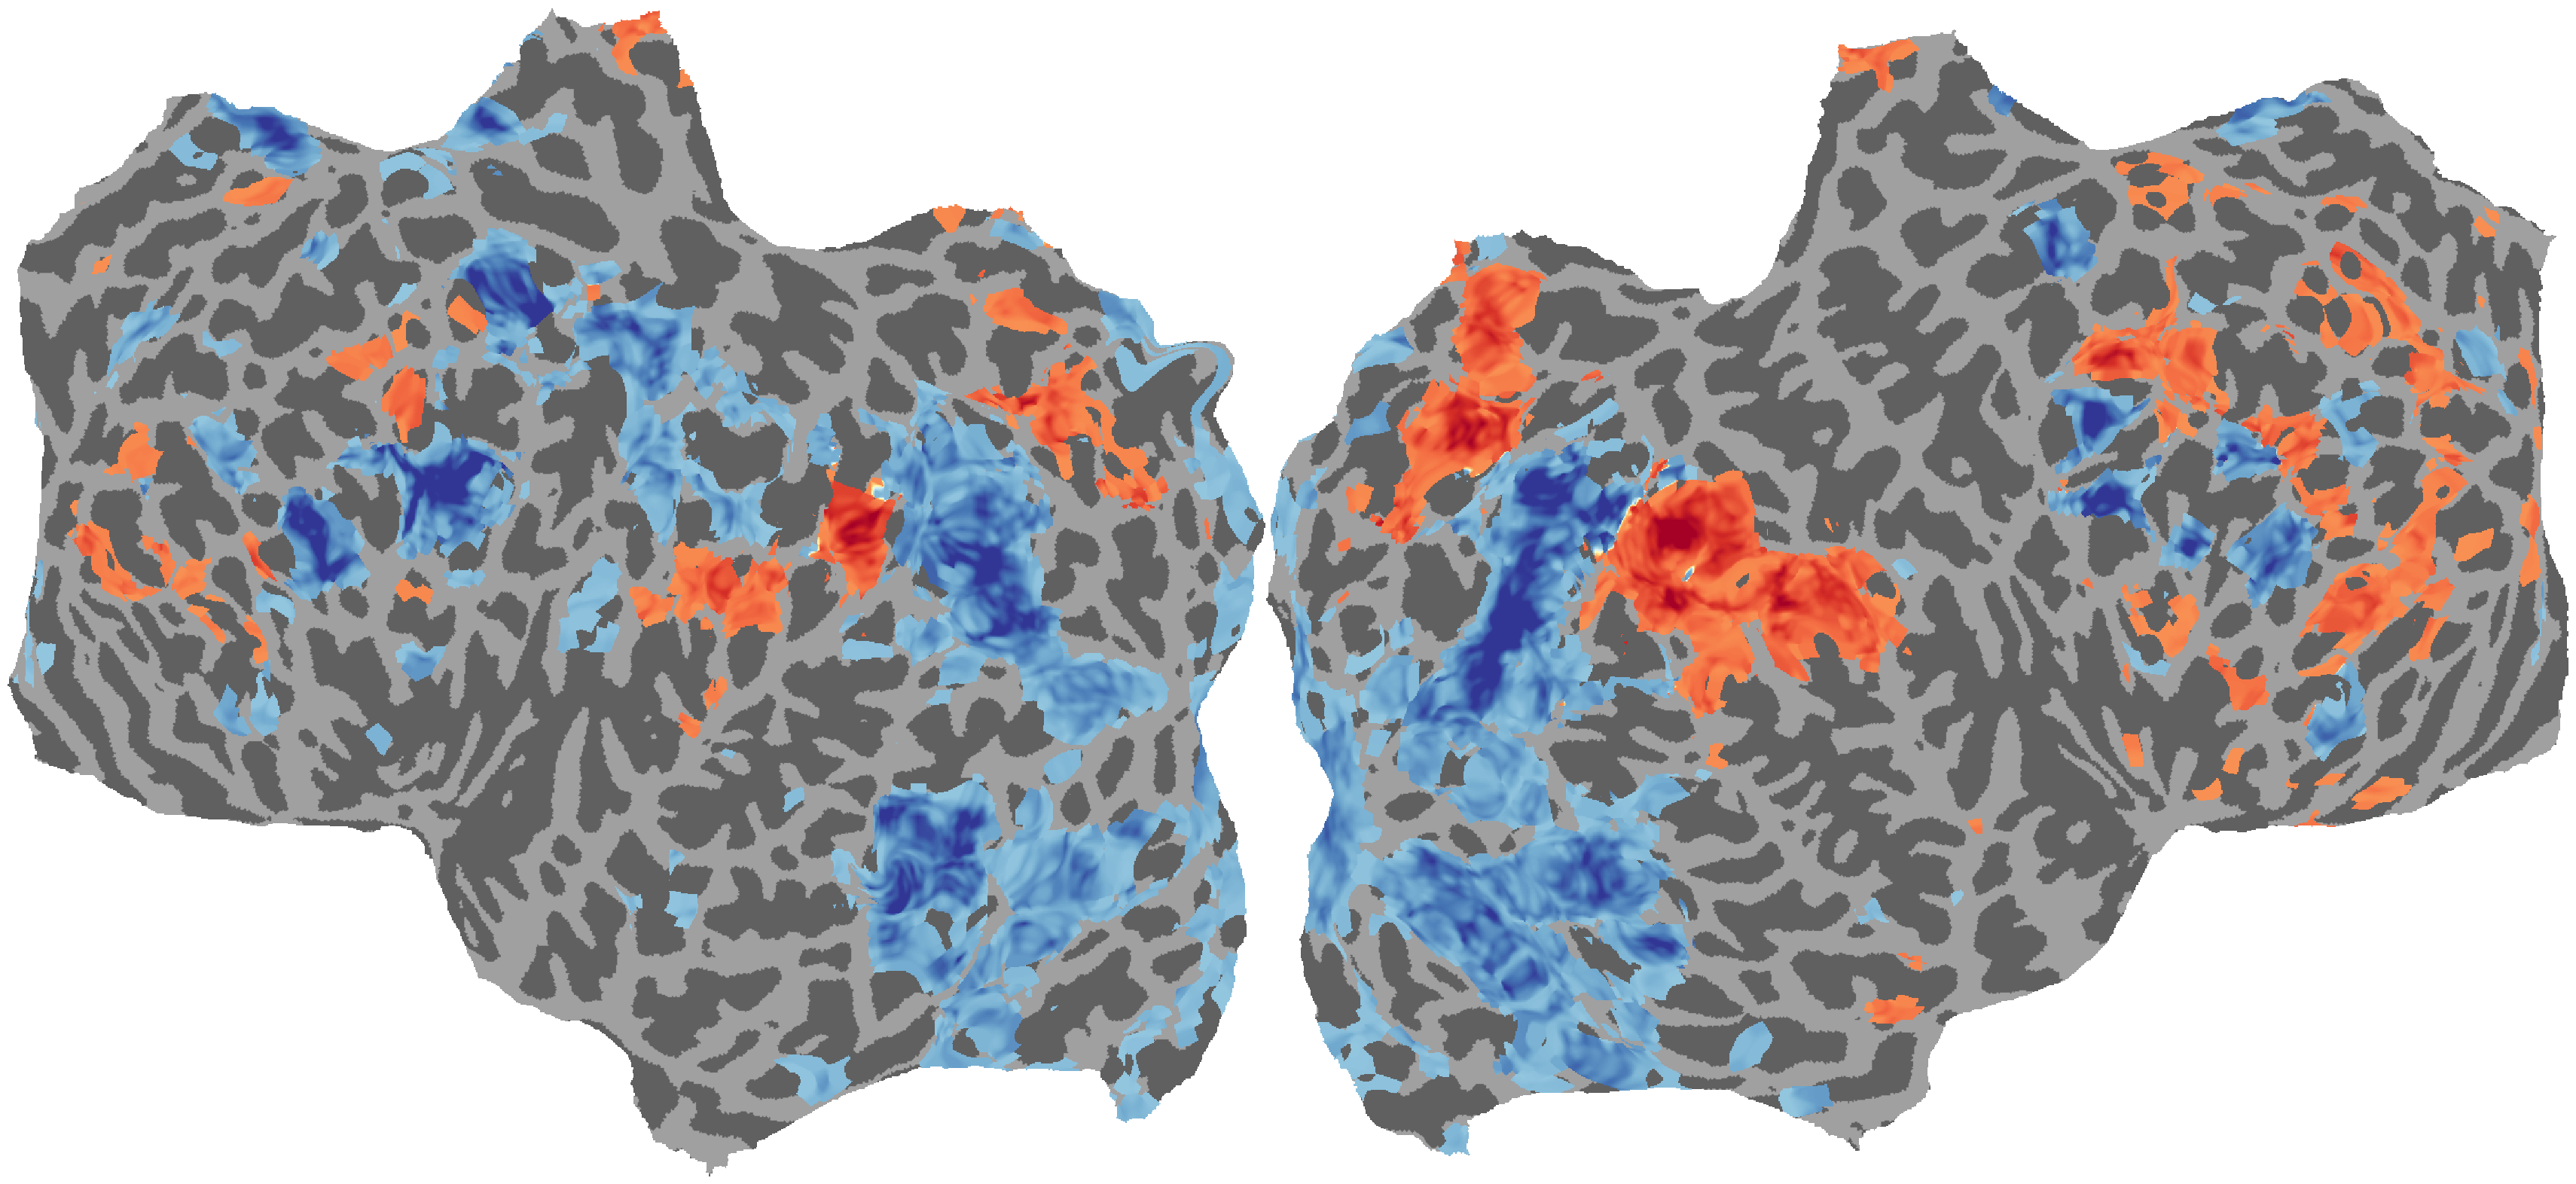

In [6]:

# Select contrast to display
contrast = "HitvCorrectRej" # choose from: [HitvCorrectRej, HitWithinvCorrectRej, HitBtwnvCorrectRej]

# set the p value threshold (uncorrected)
thresh = 0.0001

# set to True to export .png file
save_fig = False


for s in ["01", "02", "03", "06"]:
    
    vals_path = f"{glm_path}/sub-{s}/glm/sub-{s}_task-things_space-T1w_contrast-{contrast}_stat-t_desc-fromBetas_statmap.nii.gz"
    vals_arr = np.swapaxes(nib.load(vals_path).get_fdata(), 0, -1)

    p_path = f"{glm_path}/sub-{s}/glm/sub-{s}_task-things_space-T1w_contrast-{contrast}_stat-p_desc-fromBetas_statmap.nii.gz"
    p_arr = np.swapaxes(nib.load(p_path).get_fdata(), 0, -1)

    # find t-score cutoff for p < threshold, e.g., 0.0001
    t_min = np.min(np.absolute(vals_arr[np.logical_and(p_arr < thresh, vals_arr!= 0.0)]))
    
    # re-load t-scores but apply light smoothing to remove very small clusters in unsmoothed stats map
    vals_arr = np.swapaxes(smooth_img(nib.load(vals_path), fwhm=3).get_fdata(), 0, -1)
    
    # mask t scores with below-threshold p-values
    vals_arr[np.absolute(vals_arr) < t_min] = np.nan

    my_vol = cortex.Volume(
        vals_arr,
        f'sub-{s}',
        'align_auto',
        vmin=-8,
        vmax=8,
        cmap='RdYlBu_r', # RdBu, RdYlBu, Spectral_r, coolwarm
    )

    fig = plt.figure(figsize=(34,20))
    cortex.quickshow(
        my_vol,
        pixelwise=True,
        with_colorbar=False,
        nanmean=True,
        with_curvature=True,
        sampler='trilinear', 
        with_labels=False,
        with_rois=True,
        curv_brightness=1.0,
        dpi=300, 
        fig=fig,
    )

    if save_fig:
        fig.savefig(f'{fig_save_path}/sub-{s}_glmMemo_contrast-{contrast}_flatmap.png', dpi=300)

    

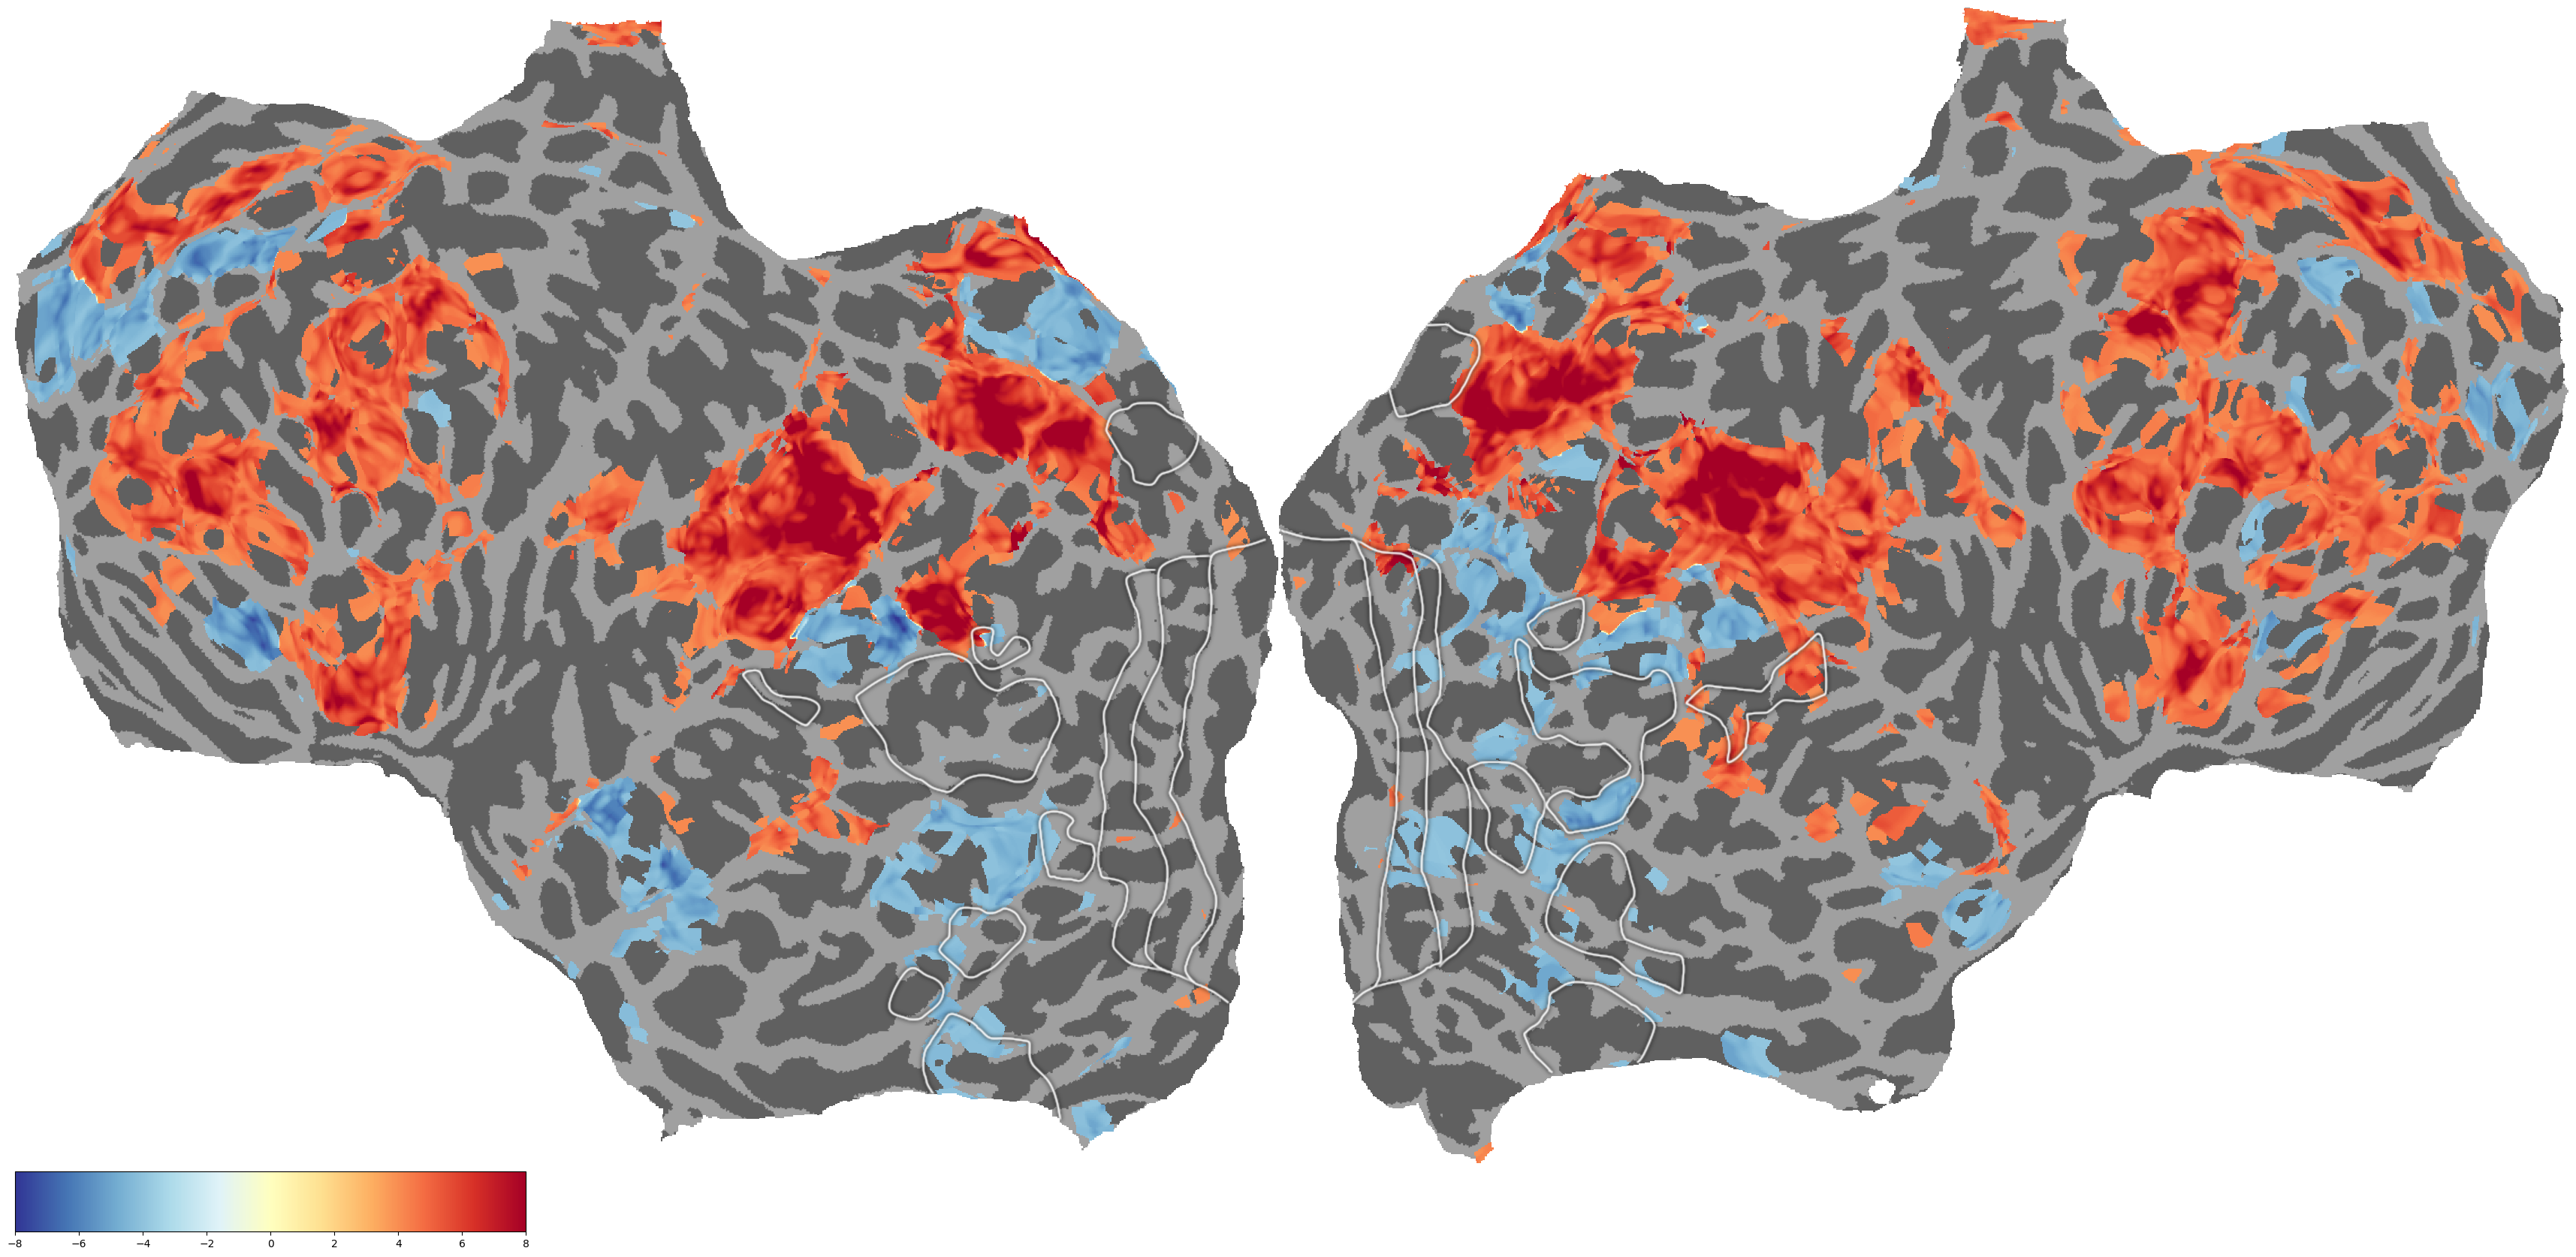

In [7]:
"""
Example: produce figure with color bar (to add to final composite figure)
"""

# Select subject number ["01", "02". "03", "06"]
s = "01"

# Select contrast to display
contrast = "HitvCorrectRej" # choose from: [HitvCorrectRej, HitWithinvCorrectRej, HitBtwnvCorrectRej]

# set the p value threshold (uncorrected)
thresh = 0.0001

# set to True to export .png file
save_fig = False


vals_path = f"{glm_path}/sub-{s}/glm/sub-{s}_task-things_space-T1w_contrast-{contrast}_stat-t_desc-fromBetas_statmap.nii.gz"
vals_arr = np.swapaxes(nib.load(vals_path).get_fdata(), 0, -1)

p_path = f"{glm_path}/sub-{s}/glm/sub-{s}_task-things_space-T1w_contrast-{contrast}_stat-p_desc-fromBetas_statmap.nii.gz"
p_arr = np.swapaxes(nib.load(p_path).get_fdata(), 0, -1)

# find t-score cutoff for p < threshold, e.g., 0.0001
t_min = np.min(np.absolute(vals_arr[np.logical_and(p_arr < thresh, vals_arr!= 0.0)]))
    
# re-load t-scores but apply light smoothing to remove tiny specs in unsmoothed stats map
vals_arr = np.swapaxes(smooth_img(nib.load(vals_path), fwhm=3).get_fdata(), 0, -1)
    
# mask t scores with below-threshold p-values
vals_arr[np.absolute(vals_arr) < t_min] = np.nan

my_vol = cortex.Volume(
    vals_arr,
    f'sub-{s}',
    'align_auto',
    vmin=-8,
    vmax=8,
    cmap='RdYlBu_r', # RdBu, RdYlBu, Spectral_r, coolwarm
)    

fig = plt.figure(figsize=(34,20))
cortex.quickshow(
    my_vol,
    pixelwise=True,
    colorbar_location='left',
    nanmean=True,
    with_curvature=True,
    sampler='trilinear',
    with_labels=False,
    with_rois=True,
    curv_brightness=1.0,
    dpi=300, 
    fig=fig,
)

if save_fig:
    fig.savefig(f'{fig_save_path}/sub-{s}_glmMemo_contrast-{contrast}_desc-wCbar_flatmap.png', dpi=300)
    